# Online inference with the Ensemble Kalman filter

In [1]:
import jax
import numpy as np
import pandas as pd
import jax.numpy as jnp
import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial

In [143]:
from jax.flatten_util import ravel_pytree
import flax.linen as nn

In [2]:
%config InlineBackend.figure_format = "retina"
plt.rcParams["font.size"] = 15
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rc("text", usetex=True)

sns.set_palette("colorblind")
palette = sns.color_palette()

## Ensemble KF

In [4]:
key = jax.random.PRNGKey(314)
key_data, key_filter = jax.random.split(key)
key_x, key_y, key_coef, key_samples = jax.random.split(key_data, 4)

In [146]:
m = 1
n_test = 200
n_samples = 500 + n_test

# coefs = jax.random.uniform(key_coef, shape=(m,) ,minval=-3, maxval=3)
coefs = jnp.array([0.1, 0.8, 0.3, -0.1])
xmin, xmax = -4, 4
X = jax.random.uniform(key_x, (n_samples, m)) * (xmax - xmin) + xmin
Phi = jnp.c_[X ** 0, X ** 1, X ** 2, X** 3]

errs = jax.random.normal(key_y, (n_samples,))
y = jnp.einsum("sm,m->s", Phi, coefs) + errs
y = jnp.atleast_2d(y).T

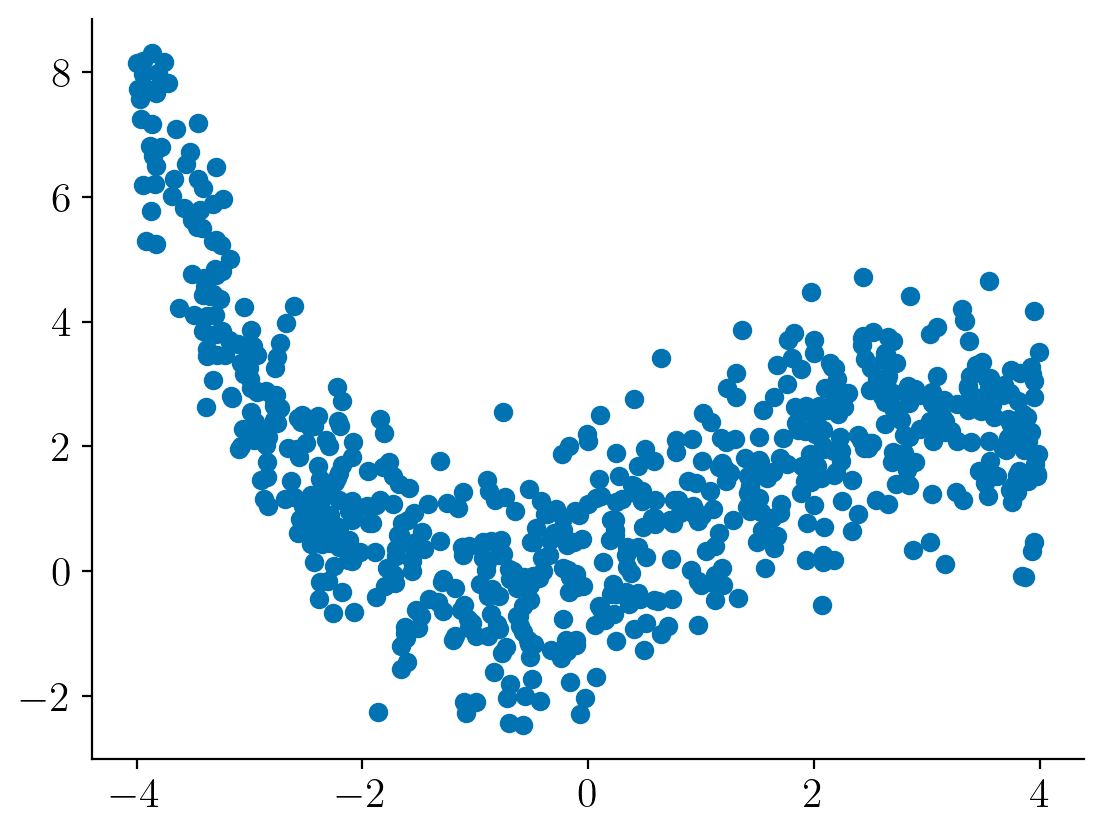

In [147]:
plt.scatter(X, y)

In [148]:
key_init, key_scan = jax.random.split(key_filter, )

In [149]:
model = MLP()

In [154]:
@partial(jax.vmap, in_axes=(0, None))
def h(theta, x):
    return theta @ x

@partial(jax.vmap, in_axes=(None, 0))
@partial(jax.vmap, in_axes=(0, None))
def h_phi(theta, x):
    phi = jnp.array([x ** 0, x ** 1, x ** 2, x ** 3])
    return theta @ phi

In [155]:
n_ensemble = 100
ensemble = jax.random.normal(key_init, (n_ensemble, len(coefs)))

In [156]:
xeval = jnp.linspace(xmin, xmax, 200)

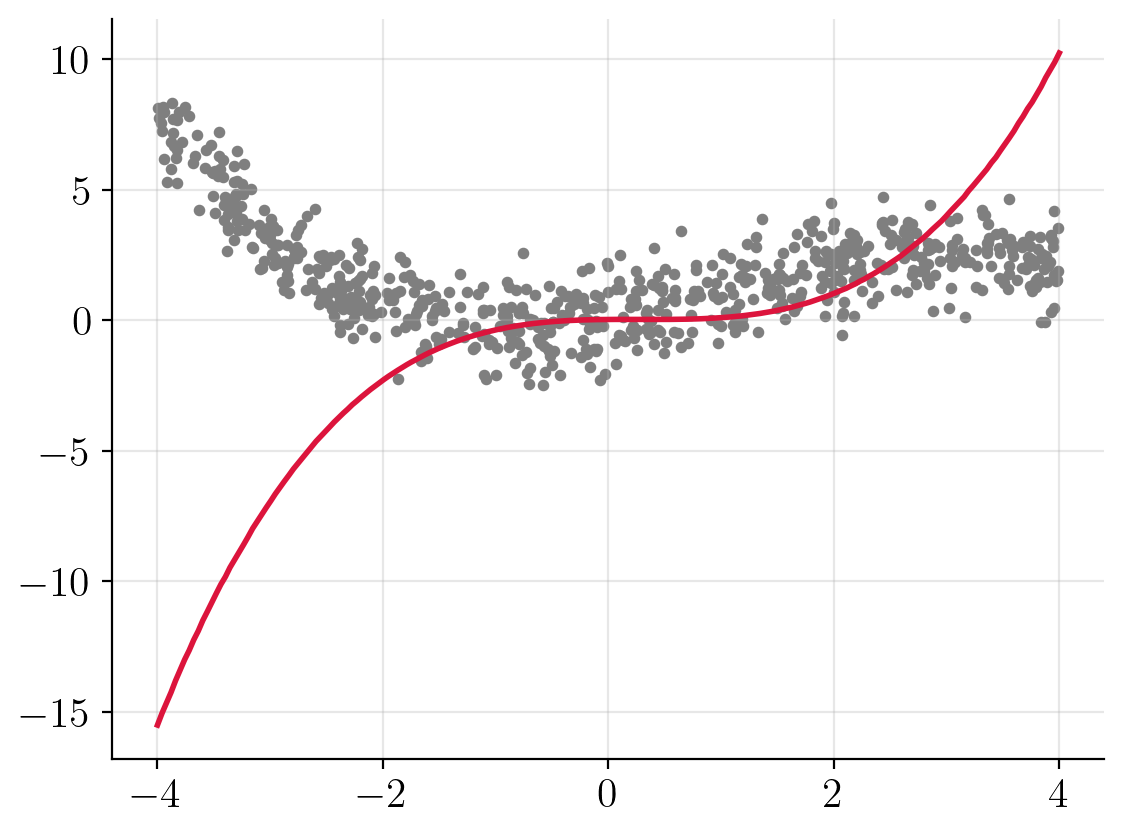

In [158]:
plt.scatter(X, y, c="tab:gray", s=10)
plt.plot(xeval, h_phi(ensemble, xeval).mean(axis=-1), c="crimson")
plt.grid(alpha=0.3)

In [159]:
def enkf_step(ensemble, xs):
    key_step, yt, phit = xs
    
    ensemble_pred = ensemble
    y_pred = h(ensemble, phit)[:, None] + jax.random.normal(key_step, (n_ensemble,1))

    ensemble_mean = ensemble_pred.mean(axis=0, keepdims=True)
    y_mean = y_pred.mean(axis=0, keepdims=True)

    ensemble_err = ensemble_pred - ensemble_mean
    y_err = y_pred - y_mean
    CT = jnp.einsum("si,sj->ji", ensemble_err, y_err) / n_ensemble
    VT = jnp.einsum("si,sj->ji", y_err, y_err) / n_ensemble
    K = jnp.linalg.solve(VT, CT).T

    ensemble = ensemble_pred + jnp.einsum("ij,sj->si", K, yt - y_pred)
    return ensemble, ensemble

In [160]:
keys = jax.random.split(key_scan, n_samples)

In [161]:
xs_hist = (keys, y, Phi)
ensemble_final, ensemble_hist = jax.lax.scan(enkf_step, ensemble, xs_hist)

In [162]:
ensemble_hist.shape

(700, 100, 4)

In [163]:
coefs

Array([ 0.1,  0.8,  0.3, -0.1], dtype=float32)

In [164]:
ensemble_final.mean(axis=0)

Array([ 0.08656066,  0.8396369 ,  0.31419843, -0.09853343], dtype=float32)

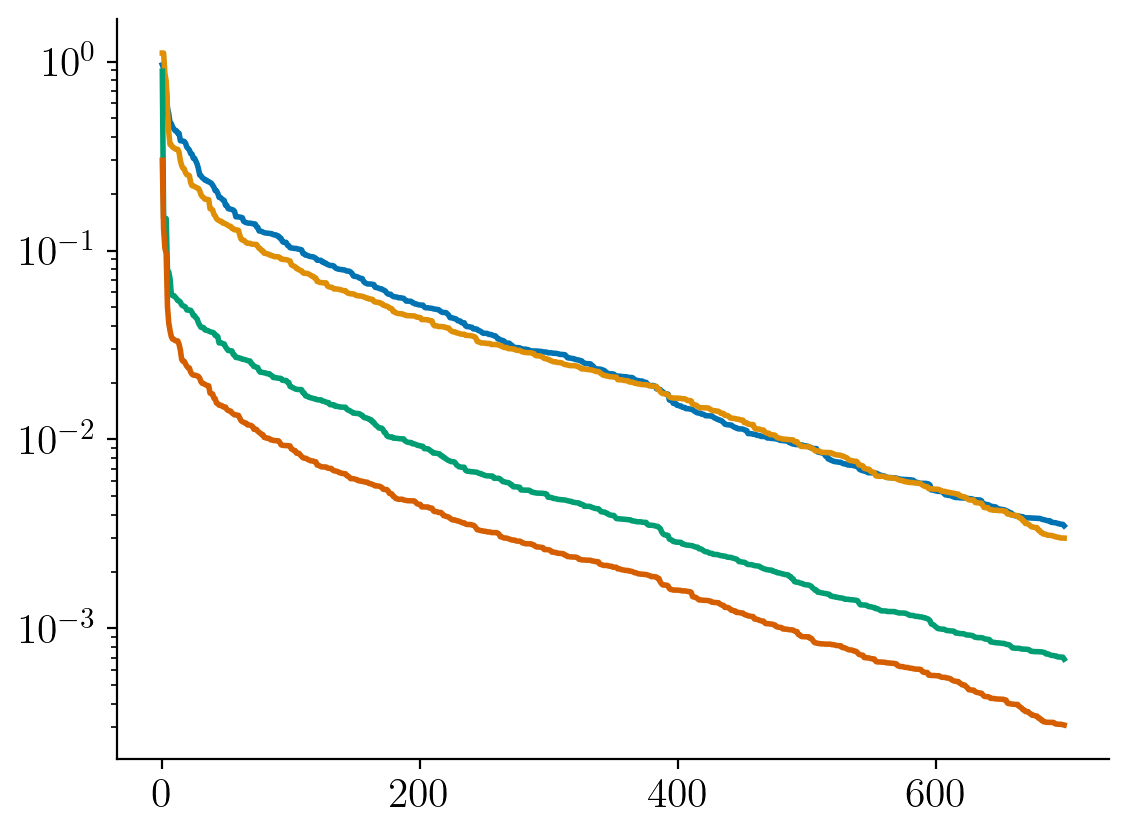

In [165]:
plt.plot(ensemble_hist.std(axis=1))
plt.yscale("log")

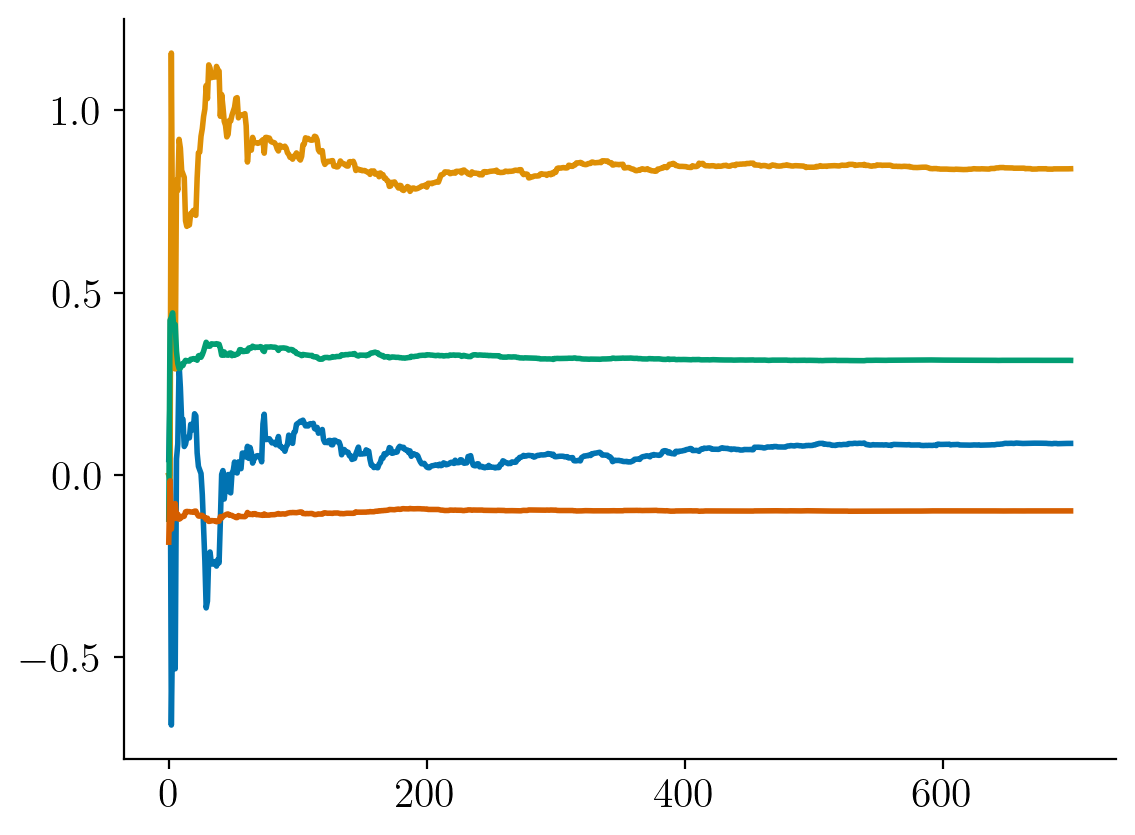

In [166]:
plt.plot(ensemble_hist.mean(axis=1))

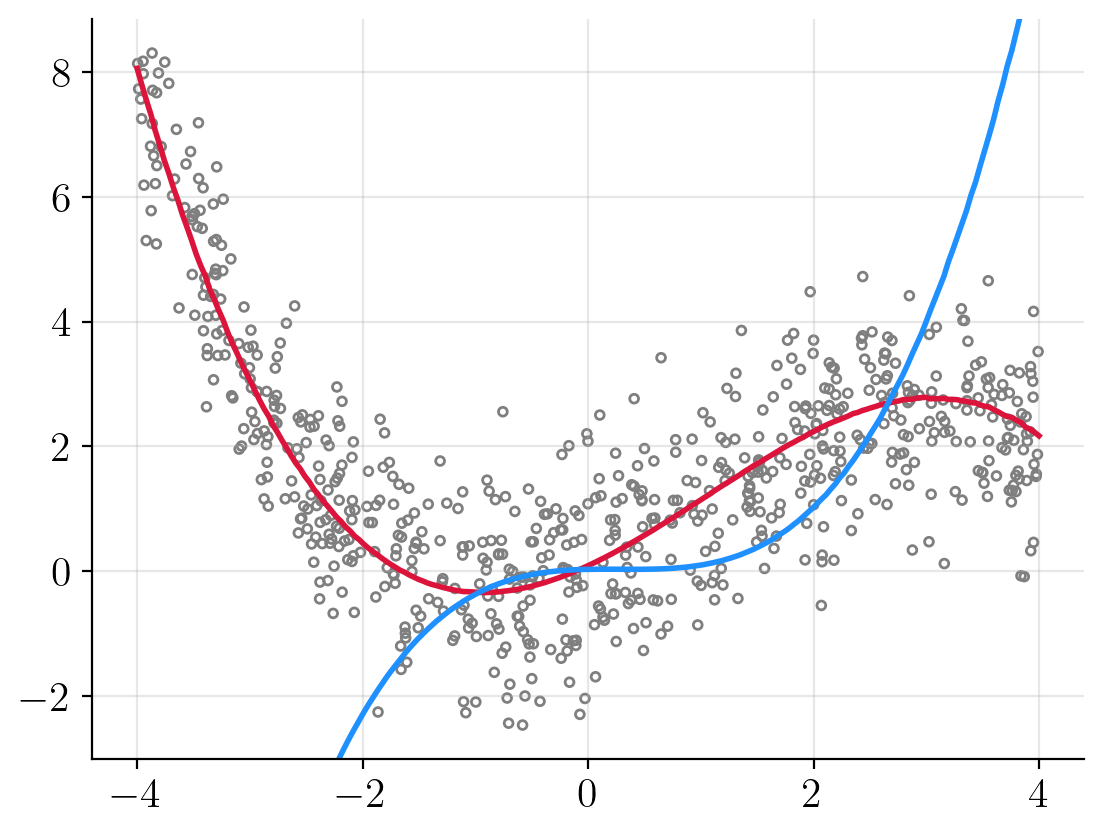

In [167]:
plt.scatter(X, y, c="none", s=10, edgecolor="tab:gray")
plt.plot(xeval, h_phi(ensemble_final, xeval).mean(axis=-1), c="crimson")
ymin, ymax = plt.ylim()
plt.plot(xeval, h_phi(ensemble, xeval).mean(axis=-1), c="dodgerblue")
plt.ylim(ymin, ymax)
plt.grid(alpha=0.3)

## An MLP

In [245]:
class MLP(nn.Module):
    def setup(self):
        self.activation = nn.relu
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(5)(x)
        x = self.activation(x)
        x = nn.Dense(5)(x)
        x = self.activation(x)
        x = nn.Dense(5)(x)
        x = self.activation(x)
        x = nn.Dense(1)(x)
        # x = nn.sigmoid(x)
        return x

In [246]:
model = MLP()

In [247]:
ensemble_init = model.init(key_init, X[0])
params, rfn = ravel_pytree(ensemble_init)
ensemble = jax.random.normal(key_init, (n_ensemble, len(params)))

In [248]:
@partial(jax.vmap, in_axes=(0, None))
def h(theta, x):
    theta = rfn(theta)
    return model.apply(theta, x)


@partial(jax.vmap, in_axes=(None, 0))
@partial(jax.vmap, in_axes=(0, None))
def h_vmap(theta, x):
    theta = rfn(theta)
    return model.apply(theta, x)

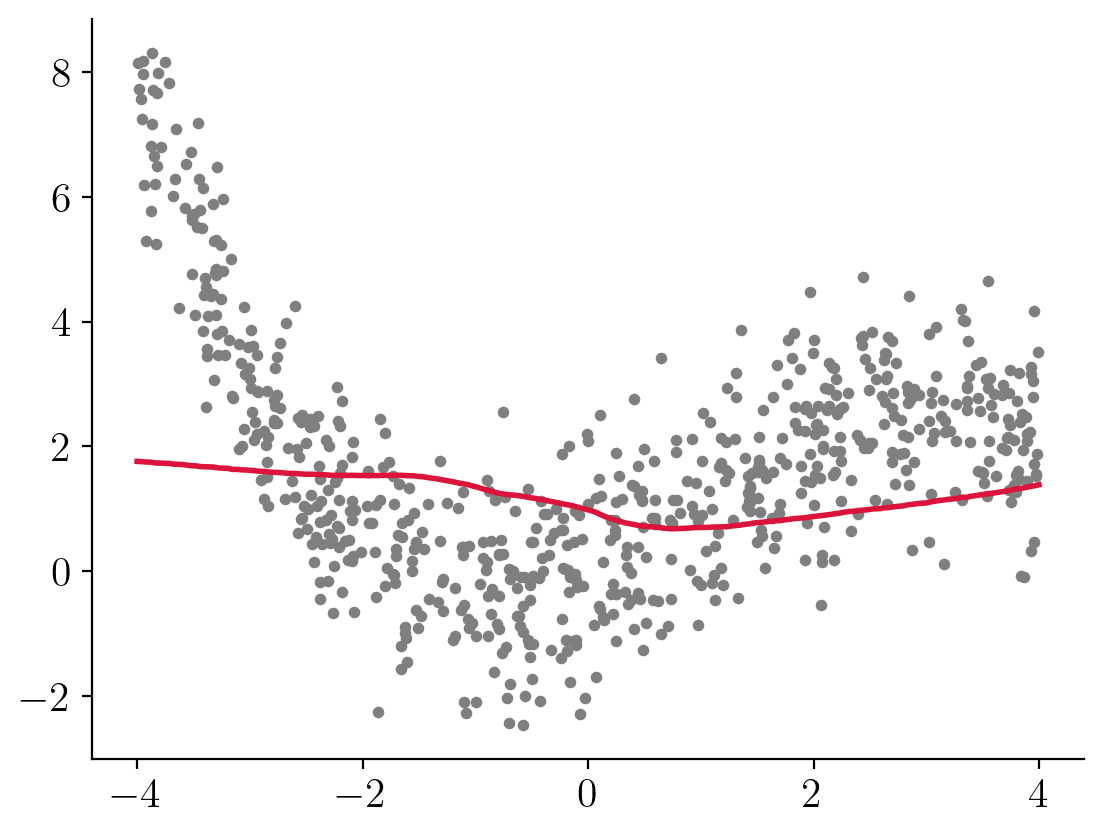

In [249]:
plt.plot(xeval, h_vmap(ensemble, xeval[:, None]).squeeze().mean(axis=-1), c="crimson")
plt.scatter(X, y, c="tab:gray", s=10)

## Inflation factor

In [262]:
def enkf_step(ensemble, xs, c=1.01):
    key_step, yt, xt = xs
    
    ensemble_pred = ensemble
    y_pred = h(ensemble, xt) + jax.random.normal(key_step, (n_ensemble,1))

    ensemble_mean = ensemble_pred.mean(axis=0, keepdims=True)
    y_mean = y_pred.mean(axis=0, keepdims=True)

    ensemble_err = ensemble_pred - ensemble_mean
    y_err = y_pred - y_mean
    CT = jnp.einsum("si,sj->ji", ensemble_err, y_err) / n_ensemble
    VT = jnp.einsum("si,sj->ji", y_err, y_err) / n_ensemble
    K = jnp.linalg.solve(c * VT, CT).T

    ensemble = ensemble_pred + jnp.einsum("ij,sj->si", K, yt - y_pred)
    return ensemble, ensemble

In [263]:
keys = jax.random.split(key_scan, n_samples)

In [264]:
xs_hist = (keys, y, X)
ensemble_final, ensemble_hist = jax.lax.scan(enkf_step, ensemble, xs_hist)

In [265]:
ensemble_hist.shape

(700, 100, 76)

In [266]:
ensemble_final.mean(axis=0)

Array([-1.8930786 , -0.24939212, -0.41340637,  2.141388  ,  0.8711429 ,
       -1.3636175 , -0.71350604, -0.31533837, -0.1862215 ,  2.1970541 ,
       -0.32070872,  0.26282305, -0.74140286,  0.72323513,  0.06256945,
       -0.6010831 , -0.76407146, -0.6157459 ,  0.3870156 ,  1.6065031 ,
       -0.74904126,  0.18444337,  0.15698364,  0.15529573, -0.335334  ,
        0.02925962,  0.9208801 , -0.07555139,  0.62281036,  0.5284304 ,
       -0.18772148, -0.34635413,  0.7834114 ,  0.37596977, -1.2149076 ,
        1.2966584 , -0.850364  ,  0.7549944 ,  0.9634286 , -0.24803081,
       -1.4746301 , -1.8329247 , -2.224223  ,  0.1252134 ,  0.48849392,
       -1.0657289 , -0.5801208 , -0.19651264,  1.0422122 ,  0.89975613,
        0.50842816,  1.595657  ,  0.02654947, -0.72118956, -0.80777127,
       -1.4270761 , -1.4217994 , -0.86169106, -0.15385082,  0.01776479,
       -0.9914308 ,  1.6399461 , -0.22034518, -0.7407317 , -0.18373503,
       -1.5783108 ,  1.4303274 , -1.6176724 ,  0.21214443,  0.31

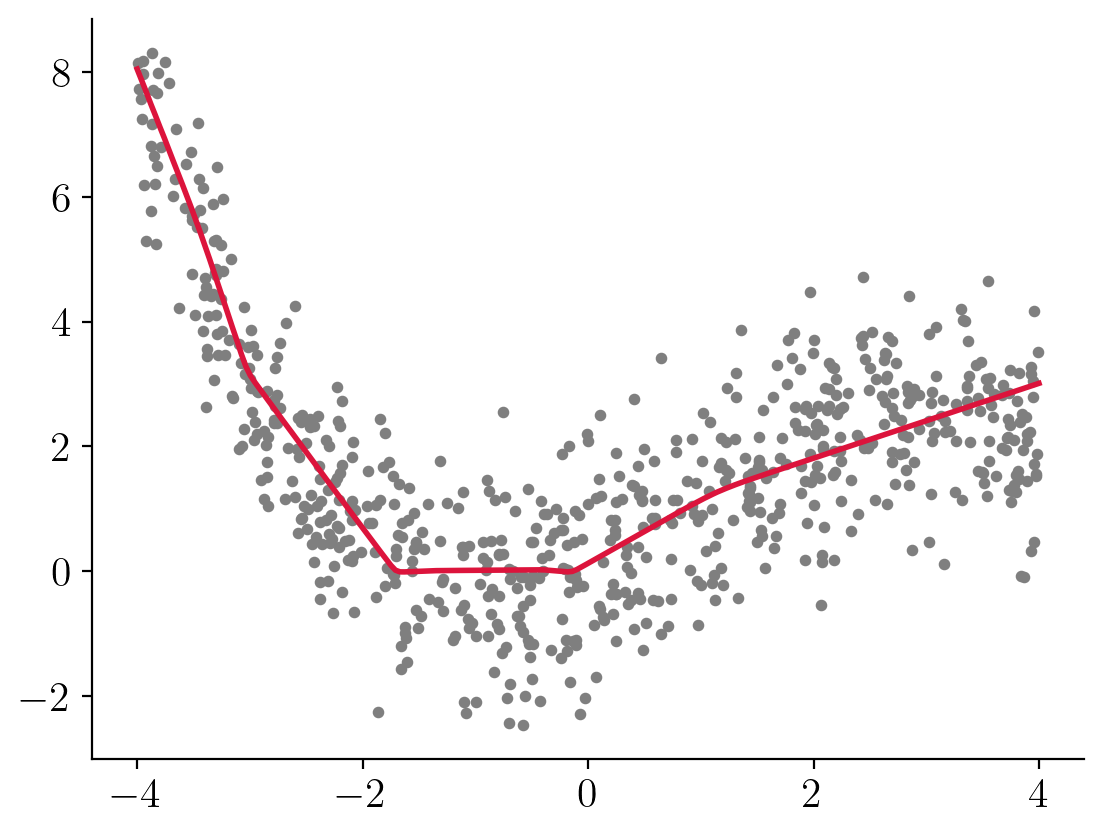

In [267]:
plt.plot(xeval, h_vmap(ensemble_final, xeval[:, None]).squeeze().mean(axis=-1), c="crimson")
plt.scatter(X, y, c="tab:gray", s=10)

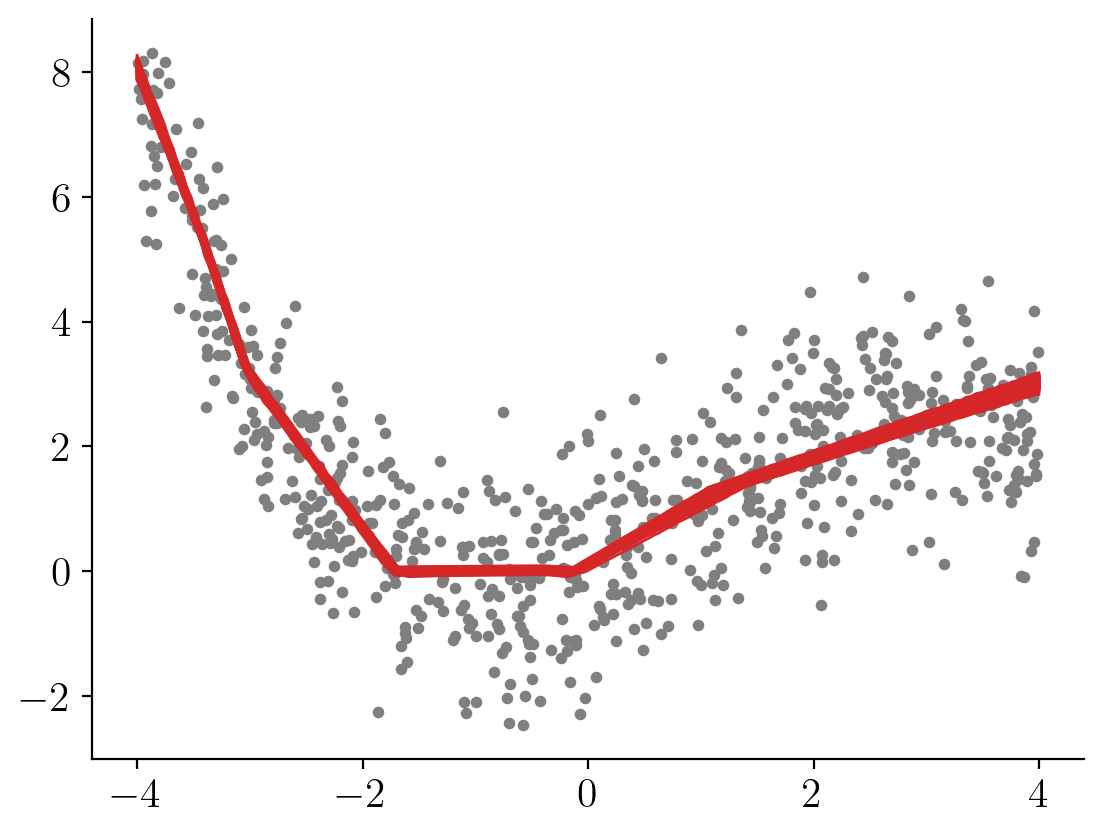

In [274]:
plt.plot(xeval, h_vmap(ensemble_final, xeval[:, None]).squeeze(), c="tab:red", linewidth=1)
plt.scatter(X, y, c="tab:gray", s=10)

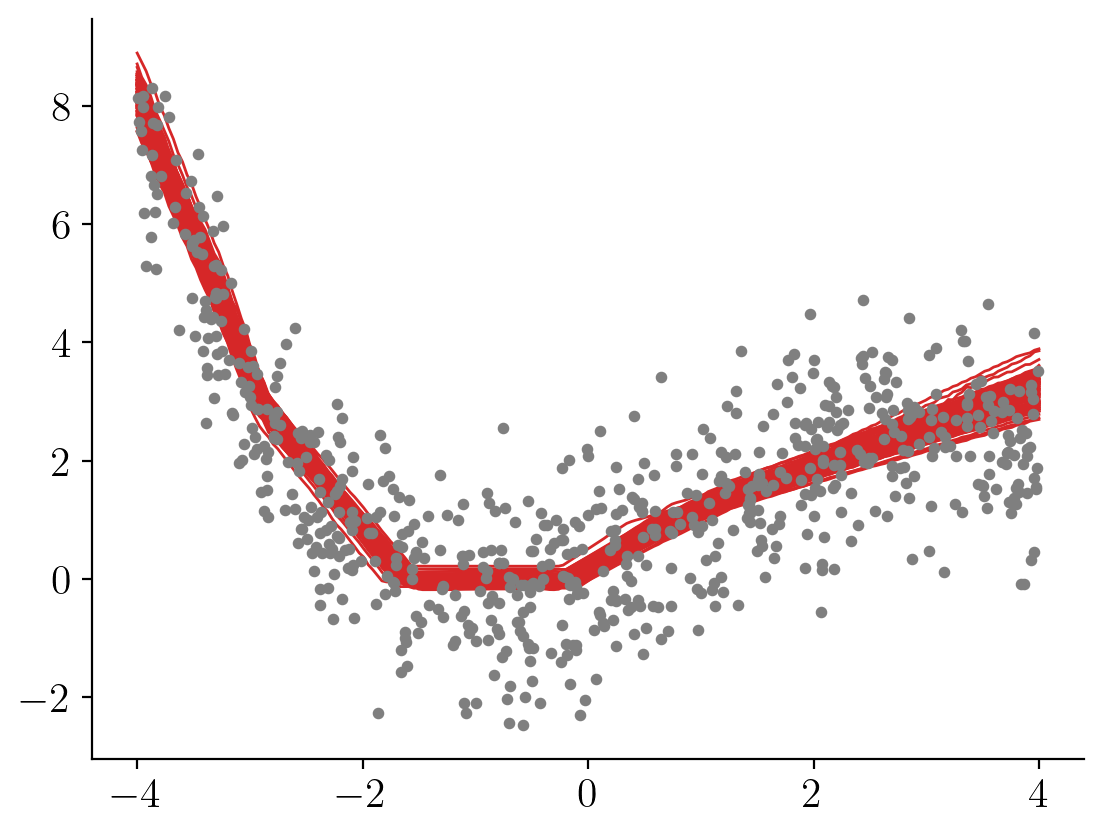

In [299]:
plt.scatter(X, y, c="tab:gray", s=10, zorder=3)
plt.plot(xeval, h_vmap(ensemble_hist[500], xeval[:, None]).squeeze(), c="tab:red", linewidth=1);

In [301]:
from matplotlib.animation import FuncAnimation

In [ ]:
fig, ax = plt.subplots()

def animate(t):
    ax.cla()
    ax.scatter(X[:t], y[:t], c="tab:gray", s=10, zorder=3)
    ax.plot(xeval, h_vmap(ensemble_hist[t], xeval[:, None]).squeeze(), c="tab:red", linewidth=1)

anim = FuncAnimation(fig, animate, np.arange(500))
anim.save("../figures/enkf-nnet.gif", fps=20)